## Dependencies

In [1]:
from skimage.metrics import structural_similarity as compare_ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np

## Functions

In [2]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                    # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr 

In [3]:
def calculate_ssim(image1, image2):
    # Read the images
    image1 = np.uint8(np.array(image1))
    image2 = np.uint8(np.array(image2))

    # Compute SSIM between two images
    ssim_score, _ = compare_ssim(image1, image2, full=True)
    return ssim_score

In [4]:
def mse(imageA, imageB):
    # Calculate MSE
    mse_value = np.mean((imageA - imageB) ** 2)
    
    return mse_value

## 1. Load Data

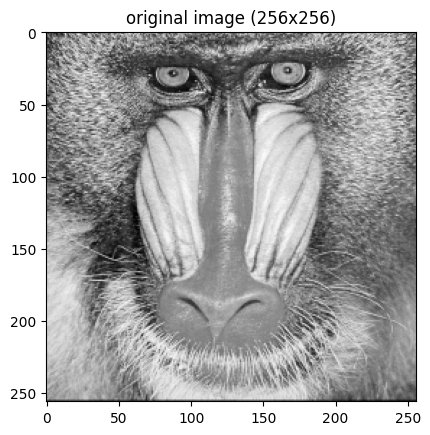

In [5]:
# paths
img_path = "Images/Baboon.tiff"
secret_bits_path = "Payload/random-binary_1Kb.txt"

# importing original image (grayscale)
original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
original_img = cv2.resize(original_img, (256, 256))

# getting all the data necessary
height, width = original_img.shape

# importing secret bits data
temp = None
secret_bits = []
with open(secret_bits_path, "r") as file1:
    temp = file1.read().replace("\t", "")
for i in temp:
    secret_bits.append(int(i))

# show the image
plt.title(f"original image ({height}x{width})")
plt.imshow(original_img, cmap='gray')

## 2. Preprocessing Data

In [6]:
# flatten the image into 1d array
img_1d = np.int16(original_img.flatten())

# creating array of every third pixel
third_pixels = [0 for _ in range(len(img_1d))]
idx = 0
for i in range(2, len(img_1d), 3):
    third_pixels[idx] = img_1d[i]
    idx += 1

## Data Embedding

In [7]:
# computing d
d = []
tp_idx = 0 # ~tp for third pixel
for i, value in enumerate(img_1d):
    d.append(value - third_pixels[tp_idx])
    if (i + 1) % 3 == 0:
        tp_idx += 1

In [8]:
# check if d is between range -5 ≤ d[i] ≤ 5
secret_key = ["10" for _ in range(len(img_1d))]
stego_pixels = img_1d.copy()
payload_capacity = 0
secret_bits_index = 0

for i, diff in enumerate(d):
    if -5 <= diff <= 5:
        payload_capacity += 1
        if secret_bits_index < len(secret_bits):
            di = d[i] + secret_bits[secret_bits_index]
            stego_pixels[i] = img_1d[i] + di
            if secret_bits[secret_bits_index] == 0:
                secret_key[i] = "11"
            elif secret_bits[secret_bits_index] == 1:
                secret_key[i] = "00"
            secret_bits_index += 1

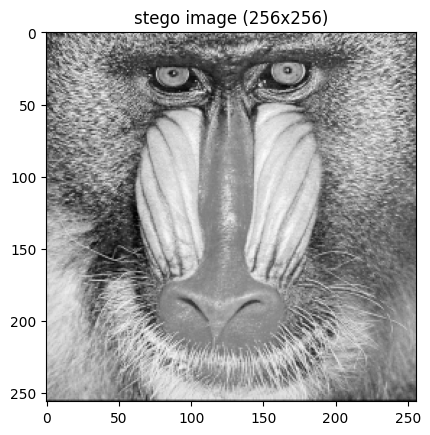

In [9]:
# reshape the stego image
stego_pixels = np.array(stego_pixels)

reshaped_img = stego_pixels.reshape(original_img.shape)

plt.title(f"stego image ({height}x{width})")
plt.imshow(reshaped_img, cmap='gray')

## Data Extraction

In [10]:
# flatten the stego image
# ~stego image is already flatten

# creating array of every third pixel
third_pixels2 = [0 for _ in range(len(stego_pixels))]
idx = 0
for i in range(2, len(stego_pixels), 3):
    third_pixels2[idx] = stego_pixels[i]
    idx += 1

In [11]:
# computing f
f = []
tp_idx = 0 # ~tp for third pixel
for i, value in enumerate(stego_pixels):
    f.append(value - third_pixels2[tp_idx])
    if (i + 1) % 3 == 0:
        tp_idx += 1

In [12]:
# check key
recovered_cover_pixel = stego_pixels.copy()
recovered_secret_bits = []

for i, val in enumerate(secret_key):
    if val != "10":
        recovered_cover_pixel[i] -= f[i] - np.ceil(f[i] / 2)
        if val == "00":
            recovered_secret_bits.append(1)
            recovered_cover_pixel[i] -= 1
        elif val == "11":
            recovered_secret_bits.append(0)
            if (i + 1) % 3 != 0 and f[i] % 2 != 0:
                recovered_cover_pixel[i] -= 1

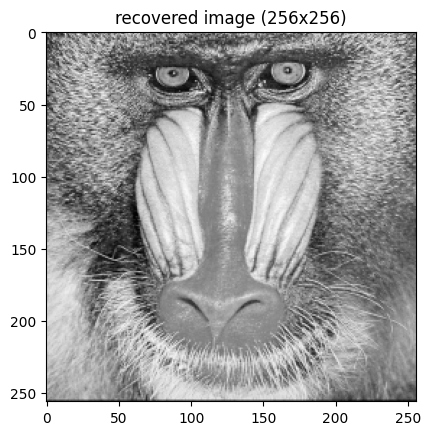

In [13]:
# reshape the cover image
real_recovered = np.array(recovered_cover_pixel)

reshaped_img = real_recovered.reshape(original_img.shape)

plt.title(f"recovered image ({height}x{width})")
plt.imshow(reshaped_img, cmap='gray')

## Testing Result

In [14]:
print("original w/ stego:")
print("PSNR:", PSNR(img_1d, stego_pixels))
print()
print("original w/ recovered img")
print("PSNR:", PSNR(img_1d, real_recovered))

original w/ stego:
PSNR: 62.50436145421218

original w/ recovered img
PSNR: 100


In [15]:
# payload capacity
print(f"payload_capacity: {payload_capacity}")
print(f"payload_capacity (bpp): {payload_capacity / height / width}")

payload_capacity: 33907
payload_capacity (bpp): 0.5173797607421875


### SSIM Score

In [16]:
ssim_score = calculate_ssim(
    np.uint8(np.array(img_1d)).reshape(original_img.shape), 
    np.uint8(np.array(stego_pixels)).reshape(original_img.shape))
print("SSIM between the images:", ssim_score)

SSIM between the images: 0.9999833418401521


## MSE Score

In [17]:
mse_value = mse(
    np.uint8(np.array(img_1d)).reshape(original_img.shape),
    np.uint8(np.array(stego_pixels)).reshape(original_img.shape))
print("Mean Squared Error:", mse_value)

Mean Squared Error: 0.036529541015625
